In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
data = pd.read_csv("./BTC.csv")
# Convert Date to datetime and sort values in ascending order
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%y')
data = data.sort_values(by='Date')

# Select only Date and Close columns for time series forecasting
data = data[['Date', 'Close']]
print("Overview of dataset \n\n" ,data.head() )

Overview of dataset 

           Date    Close
729 2018-01-01  13535.0
728 2018-01-02  14770.0
727 2018-01-03  15057.0
726 2018-01-04  14921.0
725 2018-01-05  16828.0


In [13]:
# Extract Close price values
closing_prices = data['Close'].values.reshape(-1, 1)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

In [14]:
# Split data into training and testing sets 
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [15]:
# Prepare function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [16]:
# Define sequence length
sequence_length = 60
# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [17]:
# Reshape input data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape

((1321, 60, 1), (533, 60, 1))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [19]:
# build LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=35, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0282 - val_loss: 0.0043
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0023 - val_loss: 0.0062
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0

In [27]:
# Evaluate model
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1217e-04
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.1815e-04
Train Loss: 0.0004
Test Loss: 0.0005


In [28]:
# Make predictions on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [29]:
# Evaluate metrics
rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

# Print the metrics
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 1383.90
MAE: 1011.53
R² Score: 0.9791


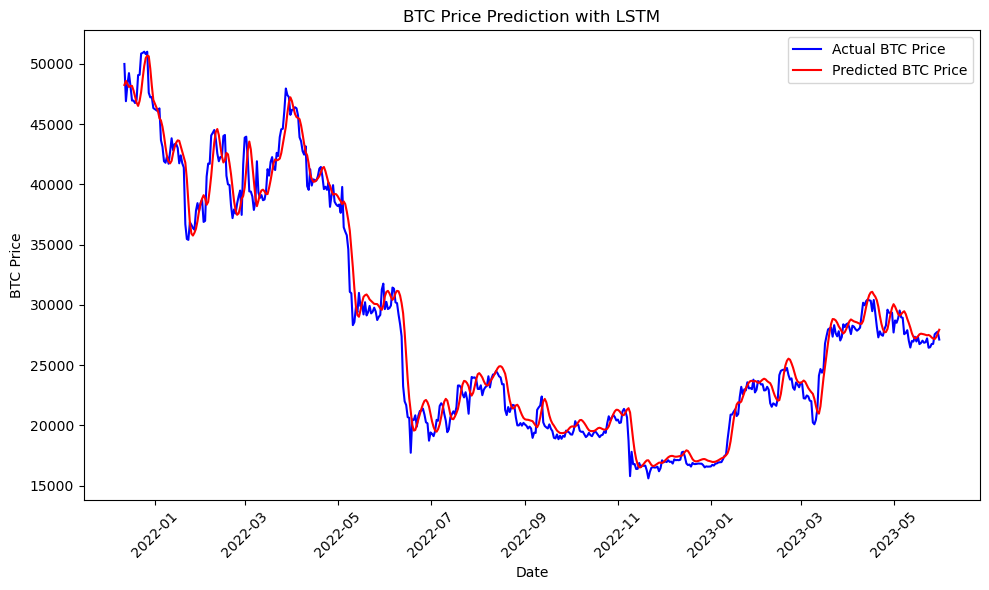

In [30]:
# Plot predicted vs. actual prices with date labels
plt.figure(figsize=(10, 6))
# Create date range for test data
test_dates = data['Date'].iloc[-len(actual_prices):]  # Select dates for the test period
# Plot actual prices with dates
plt.plot(test_dates, actual_prices, color='blue', label='Actual BTC Price')
# Plot predicted prices with dates
plt.plot(test_dates, predictions, color='red', label='Predicted BTC Price')
# Customize the plot
plt.title('BTC Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
# Rotate and format the date labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


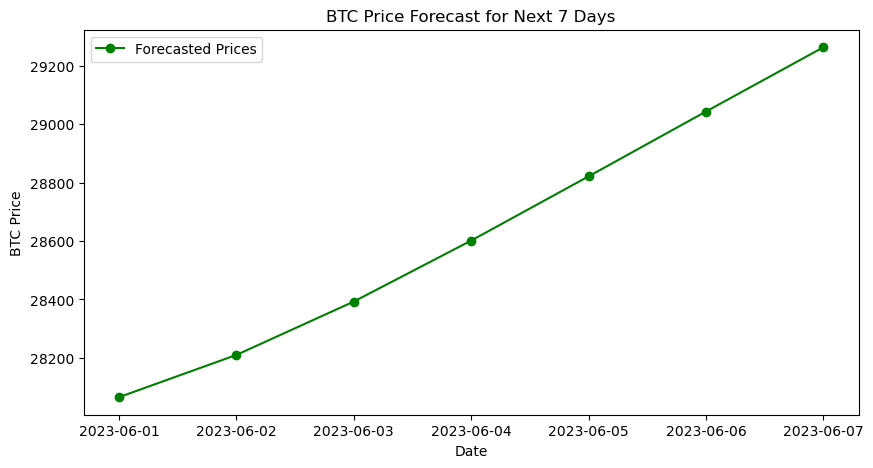

In [31]:
# Forecast the next 7 days
last_60_days = scaled_data[-60:].reshape(1, -1, 1)
future_prices = []
for _ in range(7):
    future_pred = model.predict(last_60_days)
    future_prices.append(future_pred[0, 0])
    
    # Correct reshaping to maintain 3D shape for LSTM
    future_pred_reshaped = future_pred.reshape(1, 1, 1)
    last_60_days = np.append(last_60_days[:, 1:, :], future_pred_reshaped, axis=1)

# Inverse transform future prices
future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))

# Plot future price prediction
future_dates = pd.date_range(data['Date'].iloc[-1] + pd.Timedelta(days=1), periods=7)
plt.figure(figsize=(10, 5))
plt.plot(future_dates, future_prices, marker='o', color='green', label='Forecasted Prices')
plt.title('BTC Price Forecast for Next 7 Days')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

In [32]:
# Define backtesting window (last 7 days of test data)
backtest_window = 7
# Create sequences for backtest
X_backtest = scaled_data[-(60 + backtest_window):-backtest_window].reshape(1, -1, 1)
# Forecast for the last 7 days using the model
backtest_forecast = []
for _ in range(backtest_window):
    pred = model.predict(X_backtest)
    backtest_forecast.append(pred[0, 0])
    X_backtest = np.append(X_backtest[:, 1:, :], pred.reshape(1, 1, 1), axis=1)
# Inverse transform the forecasted values
backtest_forecast = scaler.inverse_transform(np.array(backtest_forecast).reshape(-1, 1))
# Get actual prices for comparison
actual_future_prices = data['Close'].values[-backtest_window:]
# Calculate RMSE and MAE for the backtest
rmse_forecast = np.sqrt(mean_squared_error(actual_future_prices, backtest_forecast))
mae_forecast = mean_absolute_error(actual_future_prices, backtest_forecast)
print(f"Backtest RMSE: {rmse_forecast:.2f}")
print(f"Backtest MAE: {mae_forecast:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Backtest RMSE: 800.47
Backtest MAE: 715.41
